# Part 4: Canonical correlation analysis on SSVEP dataset

Welcome to the fourth part.  In this part, we shall try canonical correlation analysis on SSVEP.  SSVEP is a very simple neuro paradigm where the brain frequency will resemble to the frequency of the attended stimuli.  For example, if I am looking at a circle flicking at 6Hz, my brain signal will oscillate at 6Hz as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import create_info
from mne.io import RawArray
from mne.time_frequency import psd_welch

## 1. Loading the data

In [2]:
df = pd.read_csv('data/ssvep-20trials-3s-chaky-bigsquare.csv')

In [3]:
df.shape #check the size of 0

(62436, 10)

Let's rename our channel

In [4]:
df.rename(columns={'Unnamed: 1':'O1','Unnamed: 2':'Oz', 'Unnamed: 3':'O2'}, inplace=True)

In [5]:
df.head()

,timestamps,O1,Oz,O2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Marker
0,62389.150,38956.250,27233.611,44154.887,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
1,62389.150,39004.645,27278.182,44197.668,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
2,62389.151,39005.805,27278.383,44199.301,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
3,62389.152,38978.270,27251.068,44177.395,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
4,62389.152,38944.137,27219.082,44149.145,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0


Let's drop the channel we did not use.

In [6]:
df = df.drop(["timestamps", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

In [7]:
df.head()

,O1,Oz,O2,Marker
0,38956.250,27233.611,44154.887,0
1,39004.645,27278.182,44197.668,0
2,39005.805,27278.383,44199.301,0
3,38978.270,27251.068,44177.395,0
4,38944.137,27219.082,44149.145,0


So in our dataset, we got three targets flashing at 6Hz, 10Hz, and 15Hz.  Each target happens 10 times.  They are represented by label of 1, 2, 3 respectively.

In [8]:
print(df[df.Marker==2].shape) #10hz
print(df[df.Marker==1].shape) #6hz
print(df[df.Marker==3].shape) #15hz

(20, 4)
(20, 4)
(20, 4)


In [9]:
df[df.Marker==3]

,O1,Oz,O2,Marker
3502,39410.773,27877.766,45026.629,3
6523,39726.336,28277.191,45611.887,3
9544,40148.473,28786.275,46270.840,3
12580,40494.566,29369.209,46862.020,3
15601,40471.680,29290.598,47066.648,3
18623,41030.492,29709.939,47910.137,3
21644,41887.215,30636.396,48849.848,3
24665,41506.543,30342.336,48827.363,3
27700,41632.316,30459.996,49022.582,3
30721,41729.230,30484.383,49195.586,3


## 2. Transform Data into Raw MNE object

In [10]:
def df_to_raw(df):
    sfreq = 125  #our OpenBCI headset sampling rate
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)   

    return raw

In [11]:
raw = df_to_raw(df)

Creating RawArray with float64 data, n_channels=4, n_times=62436
    Range : 0 ... 62435 =      0.000 ...   499.480 secs
Ready.


Effective window size : 2.048 (s)


/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


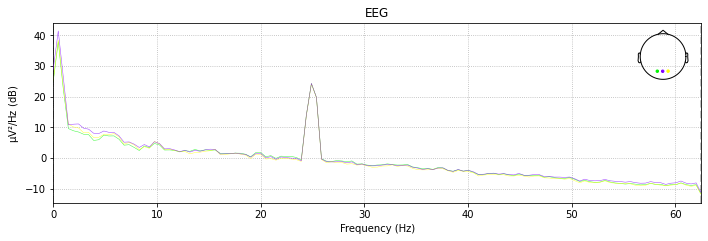

In [12]:
 raw.compute_psd().plot()

## 3. Preprocessing

### Notch Filter

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 125Hz (250Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 125 Hz.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 825 samples (6.600 sec)

Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


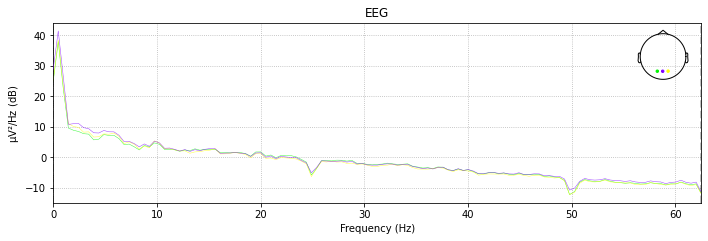

In [13]:
raw.notch_filter([25, 50], filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem
#observe that the 50Hz noise is now gone, yay!
raw.compute_psd().plot()

### Band pass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 62 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 62.00 Hz: -6.02, -6.02 dB

Effective window size : 2.048 (s)


/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


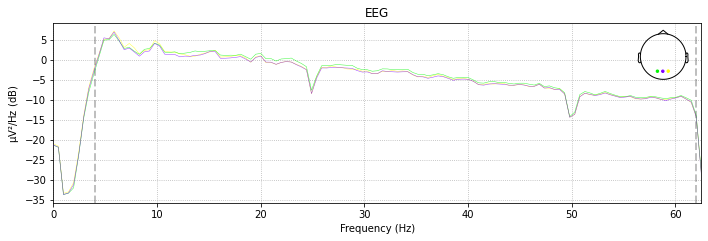

In [14]:
#since we use 6hz, 10hz, and 15hz, 
#we will take five harmonics, which maximum freq is 15 x 4 = 60
#we will take +- 2 at each end, thus 6-2 = 4, and 60+2 = 62
#these numbers are made up by me; you can try different numberes
raw.filter(4, 62, method='iir')

#this should also automatically remove any slow drift under 1Hz
raw.compute_psd().plot()

## 3. Epoching

In [15]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [16]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'6Hz': 1, '10Hz' : 2, '15Hz' : 3}
tmin=-0.5
tmax=3
eeg_channels = mne.pick_types(raw.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks=picks)

60 events found
Event IDs: [1 2 3]
sample drop %:  0.0


## 4. Checking stimuli-specific PSD

Effective window size : 8.224 (s)
Effective window size : 8.224 (s)
Effective window size : 8.224 (s)


<decorator-gen-321>:4: FutureWarning: NOTE: psd_welch() is a deprecated function. Function ``psd_welch()`` is deprecated; for Raw/Epochs/Evoked instances use ``spectrum = instance.compute_psd(method="welch")`` instead, followed by ``spectrum.get_data(return_freqs=True)``.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


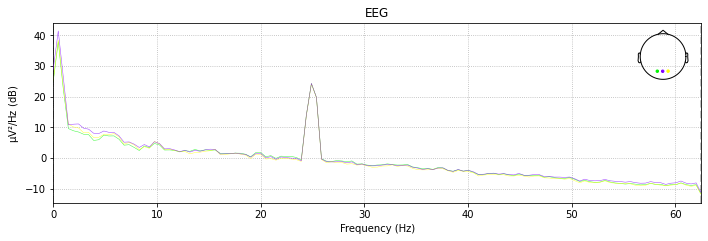

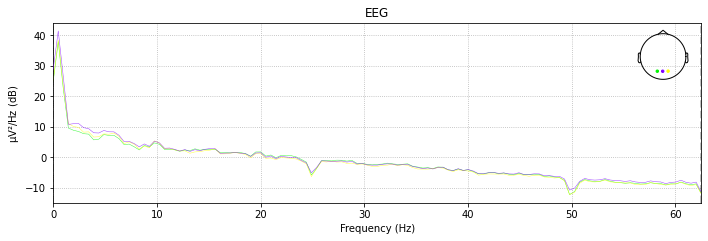

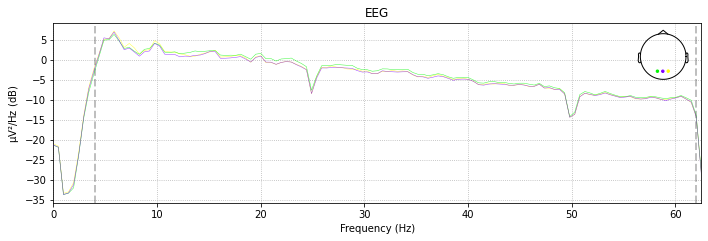

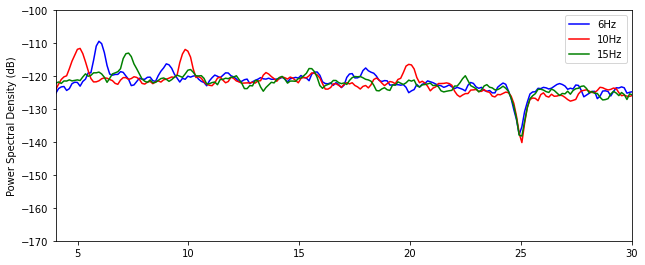

In [17]:
fig = plt.figure(figsize=(10, 4))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

psd1, freq1 = psd_welch(epochs['6Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['10Hz'], n_fft=1028, n_per_seg=256 * 3)
psd3, freq3 = psd_welch(epochs['15Hz'], n_fft=1028, n_per_seg=256 * 3)

logpsd1 = 10 * np.log10(psd1)
logpsd2 = 10 * np.log10(psd2)
logpsd3 = 10 * np.log10(psd3)

log_psd1_mean = logpsd1.mean(0)
log_psd1_std = logpsd1.mean(0)

log_psd2_mean = logpsd2.mean(0)
log_psd2_std = logpsd2.mean(0)

log_psd3_mean = logpsd3.mean(0)
log_psd3_std = logpsd3.mean(0)

axes.plot(freq1, log_psd1_mean[[0,2], :].mean(0), color='b', label='6Hz')
axes.plot(freq2, log_psd2_mean[[0,2], :].mean(0), color='r', label='10Hz')
axes.plot(freq2, log_psd3_mean[[0,2], :].mean(0), color='g', label='15Hz')

axes.set_title('')
axes.set_ylabel('Power Spectral Density (dB)')
axes.set_xlim(4, 30)
axes.set_ylim(-170, -100)
axes.legend()

plt.show()

As we can see, we can see the stimuli specific PSDs oscillating at its frequencies and harmonics.

## 5. Canonical Correlation Analysis

Canonical correlation analysis is likely the most standard process to analyze which stimuli belongs to which frequency.  Even it is a very old technique, but it works great here.

Note: The code below may look hard, but once you look closely, it's not really hard.

In [18]:
import scipy
from scipy.stats import pearsonr, mode
from sklearn.cross_decomposition import CCA

First, we shall create a function that would help us filter each sub-band.

For example, we can try the band of 4Hz to 8Hz, and then do a correlation.

This filterbank is much more accurate than non-filterbank version.

In [19]:
def filterbank(eeg, fs, idx_fb):    
    if idx_fb == None:
        warnings.warn('stats:filterbank:MissingInput '\
                          +'Missing filter index. Default value (idx_fb = 0) will be used.')
        idx_fb = 0
    elif (idx_fb < 0 or 9 < idx_fb):
        raise ValueError('stats:filterbank:InvalidInput '\
                          +'The number of sub-bands must be 0 <= idx_fb <= 9.')
            
    if (len(eeg.shape)==2):
        num_chans = eeg.shape[0]
        num_trials = 1
    else:
        _, num_chans, num_trials = eeg.shape
    
    # Nyquist Frequency = Fs/2N
    Nq = fs/2
    
    passband = [6, 14, 22, 30, 38, 46, 54, 62, 70, 78]
    stopband = [4, 10, 16, 24, 32, 40, 48, 56, 64, 72]
    Wp = [passband[idx_fb]/Nq, 90/Nq]
    
    #print("Wp: ", Wp)
    Ws = [stopband[idx_fb]/Nq, 100/Nq]
    
    #print("Ws: ", Ws)
    [N, Wn] = scipy.signal.cheb1ord(Wp, Ws, 3, 40) # band pass filter StopBand=[Ws(1)~Ws(2)] PassBand=[Wp(1)~Wp(2)]
    [B, A] = scipy.signal.cheby1(N, 0.5, Wn, 'bandpass') # Wn passband edge frequency
    
    y = np.zeros(eeg.shape)
    
    if (num_trials == 1):
        for ch_i in range(num_chans):
            #apply filter, zero phass filtering by applying a linear filter twice, once forward and once backwards.
            # to match matlab result we need to change padding length
            y[ch_i, :] = scipy.signal.filtfilt(B, A, eeg[ch_i, :])
        
    else:
        for trial_i in range(num_trials):
            for ch_i in range(num_chans):
                y[:, ch_i, trial_i] = scipy.signal.filtfilt(B, A, eeg[:, ch_i, trial_i])           
    return y

Second, we shall create a function that would simply create a repeating sin and cos wave representing our target frequencies.  We need to do this because we need to do a correlation between our given signal, and this reference signal.

In [20]:
def cca_reference(list_freqs, fs, num_smpls, num_harms=3):
    num_freqs = len(list_freqs)
    tidx = np.arange(1, num_smpls + 1) / fs  # time index

    y_ref = np.zeros((num_freqs, 2 * num_harms, num_smpls))
    for freq_i in range(num_freqs):
        tmp = []
        for harm_i in range(1, num_harms + 1):
            stim_freq = list_freqs[freq_i]  # in HZ
            # Sin and Cos
            tmp.extend([np.sin(2 * np.pi * tidx * harm_i * stim_freq),
                        np.cos(2 * np.pi * tidx * harm_i * stim_freq)])
        y_ref[freq_i] = tmp  # 2*num_harms because include both sin and cos

    return y_ref

Here, we shall find the correlation between the given signal and the reference frequency signal, by looping across events, and filterbanks.

In [21]:
def fbcca(eeg, list_freqs, fs, num_harms=3, num_fbs=5):
    fb_coefs = np.power(np.arange(1, num_fbs + 1), (-1.25)) + 0.25

    num_targs = len(list_freqs)
    events, _, num_smpls = eeg.shape  # 40 taget (means 40 fre-phase combination that we want to predict)
    y_ref = cca_reference(list_freqs, fs, num_smpls, num_harms)
    cca = CCA(n_components=1)  # initilize CCA

    # result matrix
    r = np.zeros((num_fbs, num_targs))
    results = np.zeros(num_targs)
    r_mode = []
    r_corr_avg = []

    for event in range(eeg.shape[0]):
        test_tmp = np.squeeze(eeg[event, :, :])  # deal with one event a time
        for fb_i in range(num_fbs):  # filter bank number, deal with different filter bank
            for class_i in range(num_targs):
                testdata = filterbank(test_tmp, fs, fb_i)  # data after filtering
                refdata = np.squeeze(y_ref[class_i, :, :])  # pick corresponding freq target reference signal
                test_C, ref_C = cca.fit_transform(testdata.T, refdata.T)
                # len(row) = len(observation), len(column) = variables of each observation
                # number of rows should be the same, so need transpose here
                # output is the highest correlation linear combination of two sets
                r_tmp, _ = pearsonr(np.squeeze(test_C),
                                    np.squeeze(ref_C))  # return r and p_value, use np.squeeze to adapt the API
                if r_tmp == np.nan:
                    r_tmp = 0
                r[fb_i, class_i] = r_tmp
        rho = np.dot(fb_coefs, r)  # weighted sum of r from all different filter banks' result
        print("rho: ", rho)
        result = np.argmax(rho)
        print("result: ", result)
        r_mode.append(result)
        print("correlation: ", abs(rho[result]))
        r_corr_avg.append(abs(rho[result]))
    print("====Most recurrent class: ====", mode(r_mode)[0][0])
    print("====Average correlation: =====", np.mean(r_corr_avg))


Now that we have our code, let's find the correlation between our signal and the three given frequencies.

In [22]:
epochs.pick_types(eeg=True)
X1 = epochs['6Hz'].get_data()
list_freqs = [6, 10, 15]
fs = 250
num_harms = 2
num_fbs = 3

print("6hz: =============================================")
fbcca(X1, list_freqs, fs, num_harms, num_fbs)

6hz: =============================================
rho:  [0.25755617 0.33524926 0.65949178]
result:  2
correlation:  0.6594917796491001
rho:  [0.33537148 0.67365617 0.51072422]
result:  1
correlation:  0.6736561691979026
rho:  [0.30174884 0.27414146 0.69992852]
result:  2
correlation:  0.6999285192845894
rho:  [0.48317676 0.39900272 0.43324982]
result:  0
correlation:  0.4831767572718295
rho:  [0.43249231 0.37407133 0.41424319]
result:  0
correlation:  0.432492312109832
rho:  [0.42429458 0.40517765 0.60926208]
result:  2
correlation:  0.609262081702428
rho:  [0.59704393 0.42768495 0.46383847]
result:  0
correlation:  0.5970439317369973
rho:  [0.49651624 0.35864786 0.41599858]
result:  0
correlation:  0.496516237226185
rho:  [0.38550271 0.38116319 0.84524035]
result:  2
correlation:  0.845240348884251
rho:  [0.58889701 0.33992156 0.62875843]
result:  2
correlation:  0.6287584342271257
rho:  [0.5747352  0.50057292 0.48143046]
result:  0
correlation:  0.574735201636837
rho:  [0.57439678 0

In [23]:
X2 = epochs['10Hz'].get_data()
print("10hz: ============================================")
fbcca(X2, list_freqs, fs, num_harms, num_fbs)

10hz: ============================================
rho:  [0.27389784 0.38697019 0.54021541]
result:  2
correlation:  0.5402154063334623
rho:  [0.24763057 0.69182858 0.47600221]
result:  1
correlation:  0.6918285762120404
rho:  [0.3214901  0.72233308 0.56632934]
result:  1
correlation:  0.7223330836229409
rho:  [0.24155354 0.822824   0.57636536]
result:  1
correlation:  0.822824002546619
rho:  [0.2760871  0.78861588 0.59215937]
result:  1
correlation:  0.7886158778797348
rho:  [0.29513864 0.6067264  0.71938128]
result:  2
correlation:  0.7193812835697987
rho:  [0.2659797  0.83319776 0.82603717]
result:  1
correlation:  0.8331977631206164
rho:  [0.39473337 0.79742097 0.73616672]
result:  1
correlation:  0.7974209690435037
rho:  [0.27742631 0.82881228 0.53083094]
result:  1
correlation:  0.8288122797359171
rho:  [0.25995435 0.90003262 0.36876037]
result:  1
correlation:  0.9000326226714541
rho:  [0.28066453 0.78811473 0.54326428]
result:  1
correlation:  0.7881147313815834
rho:  [0.137974

In [24]:
X3 = epochs['15Hz'].get_data()
print("15hz: ============================================")
fbcca(X3, list_freqs, fs, num_harms, num_fbs)

15hz: ============================================
rho:  [0.35933473 0.45682571 0.98039248]
result:  2
correlation:  0.9803924761690601
rho:  [0.35818645 0.497325   0.68968471]
result:  2
correlation:  0.6896847144595264
rho:  [0.21685489 0.4642724  0.87216735]
result:  2
correlation:  0.872167350521599
rho:  [0.26485271 0.43032939 1.0097039 ]
result:  2
correlation:  1.0097039015616343
rho:  [0.30570961 0.62145178 0.86032861]
result:  2
correlation:  0.8603286116546327
rho:  [0.3151057  0.48955774 1.00052901]
result:  2
correlation:  1.0005290089813326
rho:  [0.37629926 0.58318651 1.00534427]
result:  2
correlation:  1.0053442689881118
rho:  [0.19842089 0.40447288 1.10051767]
result:  2
correlation:  1.100517667767527
rho:  [0.23714462 0.41493763 1.19415702]
result:  2
correlation:  1.1941570179695726
rho:  [0.35095736 0.45725111 1.36718694]
result:  2
correlation:  1.3671869359460103
rho:  [0.3299844  0.40493754 1.15171862]
result:  2
correlation:  1.151718618620872
rho:  [0.24771264

As you can see, CCA is very powerful in categorizing the SSVEP signal.